In [1]:
# IMPORTS
import sys
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
from math import factorial
from librosa import feature as zcr

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh*4)

# NORMALIZING THE DYNAMICS
def normalize_dynamics_by_max_dynamic_in_file(dynamics_over_time_all_files):
    for i in range(0, len(dynamics_over_time_all_files)):
        
        max = dynamics_over_time_all_files[i].copy().flat[abs(dynamics_over_time_all_files[i]).argmax()]
        # max = np.max(dynamics_over_time_all_files[i])
        dynamics_over_time_all_files[i] = dynamics_over_time_all_files[i]/max
    return dynamics_over_time_all_files

def read_mask(directory_path, filename):
    image = cv2.imread("{0}/{1}".format(directory_path, filename))
    mask = np.where(image<255)
    return mask

def get_available_masks(directory_path):
    directory = os.fsencode(directory_path)
    masked_files = list()
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.mov'):
            masked_files.append(filename[:-4])
    return masked_files

def analyze_file(filename, mask=None):
    cap = cv2.VideoCapture("../ForAnalyze/{0}".format(filename))
    final_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)    
    average_dynamics_over_time = np.zeros(int(final_frame_count-1))
    last_average = -1
    fc=0
    ret = True
    while fc< final_frame_count-1 and ret:
        ret, frame = cap.read()
        if last_average >= 0:
            if mask:
                current_avg = np.average(frame[mask])
                average_dynamics_over_time[fc] = current_avg - last_average
                last_average = current_avg
            else:
                current_avg = np.average(frame)
                average_dynamics_over_time[fc] = current_avg - last_average
                last_average = current_avg
        else:
            if mask:
                last_average = np.average(frame[mask])
            else:
                last_average = np.average(frame)
        fc+=1
                
    return filename, average_dynamics_over_time
    
        

In [14]:
masks_directory= "../PlateletsMasks"
directory = os.fsencode("../ForAnalyze")
total_files =""
finished_files = list()
dynamics_over_time_all_files = list()
available_masks = get_available_masks(masks_directory)
# available_masks = None
mask = None
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.mp4') or filename.endswith('.avi') or filename.endswith('.mov'):
        try:
            index_in_mask = available_masks.index(filename[:-4])
        except Exception as e:
            index_in_mask = -1            
        if index_in_mask>=0:
            mask = read_mask(masks_directory, filename[:-4]+".jpg")  
            file_processed_name, result = analyze_file(filename, mask)
        else:
            file_processed_name, result = analyze_file(filename, None)
        dynamics_over_time_all_files.append(result)
        finished_files.append(file_processed_name)


In [22]:
# PLOTTING THE FILES DYNAMICS
# dynamics_over_time_all_files = normalize_dynamics_by_max_dynamic_in_file(dynamics_over_time_all_files)
smoothing_enabled = True
if smoothing_enabled:
    for i in range(0, len(dynamics_over_time_all_files)):
        dynamics_over_time_all_files[i] = savitzky_golay(dynamics_over_time_all_files[i],
                                                         window_size=5, order=3)

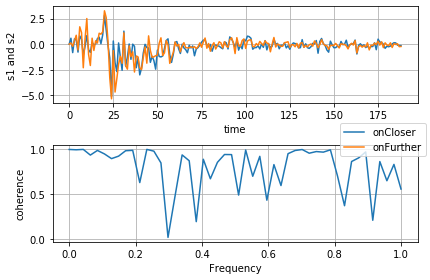

NameError: name 'smoothing_enabled' is not defined

In [15]:
#     
# fig, axs = plt.subplots(len(dynamics_over_time_all_files))
# fig.suptitle('Dynamics Over Time,\nMasks={0}'.format(True if mask else False))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
# for i in range(0, len(dynamics_over_time_all_files)):
#     axs[i].plot(dynamics_over_time_all_files[i])
#     set_size(10,5, axs[i])
#     axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
#     # axs[i].set
#     axs[i].xaxis.label.set_size(7)
#     axs[i].yaxis.label.set_size(7)
#     axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
# fig.savefig("test.png", dpi=200)

# FOR PLATELETS CORRELATION
s1 = dynamics_over_time_all_files[0] 
s2 =  dynamics_over_time_all_files[1]
# t = np.linspace(0, len(dynamics_over_time_all_files[0]), len(dynamics_over_time_all_files[0]))
t = range(0, len(dynamics_over_time_all_files[0]), 1)

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, label="{0}".format(finished_files[0][:-8][17:]))
axs[0].plot(t, s2, label="{0}".format(finished_files[1][:-8][17:]))
# axs[0].set_xlim(0, 2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

cxy, f = axs[1].cohere(s1, s2, int(len(s1)/2))
axs[1].set_ylabel('coherence')
fig.legend(loc='center right')
# axs[2].plot(t, s1-(s2*cxy))

fig.tight_layout()
plt.show()
fig.savefig("Two sides of a platelet interaction in Coll IV Control correlation_Smoothed={0}.png".format(smoothing_enabled), dpi=200)

In [20]:
# def calc_derivatives(vector):
#     derivatives_vector = np.zeros((len(vector)-1))
#     for j in range(0,len(vector)-1):
#         derivatives_vector[j] = vector[j]-vector[j+1]
#     return derivatives_vector
# 
# derivatives_of_dynamics_all_files = list()
# for i, video_dynamics in enumerate(dynamics_over_time_all_files):
#     derivatives_of_dynamics_all_files.append(calc_derivatives(video_dynamics))
# 
# fig, axs = plt.subplots(len(derivatives_of_dynamics_all_files))
# fig.suptitle('Dynamics Derivatives Over Time,\nMasks={0}'.format(True if mask else False))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
# for i in range(0, len(derivatives_of_dynamics_all_files)):
#     axs[i].plot(derivatives_of_dynamics_all_files[i])
#     set_size(10,5, axs[i])
#     axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
#     # axs[i].set
#     axs[i].xaxis.label.set_size(7)
#     axs[i].yaxis.label.set_size(7)
#     axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
# fig.savefig("test.png", dpi=200)

In [21]:
# sec_derivatives_of_dynamics_all_files = list()
# for i, video_dynamics in enumerate(derivatives_of_dynamics_all_files):
#     sec_derivatives_of_dynamics_all_files.append(calc_derivatives(video_dynamics))
# 
# fig, axs = plt.subplots(len(sec_derivatives_of_dynamics_all_files))
# fig.suptitle('Dynamics 2nd Derivatives Over Time,\nMasks={0}'.format(True if mask else False))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
# for i in range(0, len(sec_derivatives_of_dynamics_all_files)):
#     axs[i].plot(derivatives_of_dynamics_all_files[i])
#     set_size(10,5, axs[i])
#     axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
#     # axs[i].set
#     axs[i].xaxis.label.set_size(7)
#     axs[i].yaxis.label.set_size(7)
#     axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
# fig.savefig("test.png", dpi=200)


In [8]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize, MinMaxScaler

model = NMF(n_components=5)
# scaler = normalize()
test_array = dynamics_over_time_all_files.copy()

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(test_array)
normalized_X = normalize(scaled_X, norm='l1', axis=1, copy=True)

model.fit(normalized_X)
W = model.transform(normalized_X)
H = model.components_

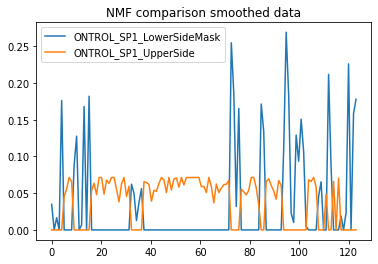

In [9]:
t=np.linspace(0, len(H[0]), len(H[0]))
plt.plot(t, H[0], t, H[1])
plt.title("NMF comparison smoothed data")
plt.legend([x[:-8][17:] for  x in finished_files])
plt.savefig("Usage of NMF sm.png")


In [16]:
zcr.zero_crossing_rate(dynamics_over_time_all_files[0])

array([[0.03466797]])

In [17]:
zcr.zero_crossing_rate(dynamics_over_time_all_files[1])

array([[0.04345703]])